In [1]:
import pandas as pd
import numpy as np
# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
from google.colab import files

In [2]:
# Upload semua dataset yang dipakai
uploaded = files.upload()

Saving rating_resto.csv to rating_resto.csv
Saving resto_id.csv to resto_id.csv
Saving user_new.csv to user_new.csv


In [3]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('rating_resto.csv')
place = pd.read_csv('resto_id.csv')
user = pd.read_csv('user_new.csv')

In [4]:
rating.head()

,User_Id,Resto_Id,Resto_Ratings
0,1,577,3
1,1,348,2
2,1,867,5
3,1,62,3
4,1,364,4


In [5]:
# Melakukan merge untuk mengambil data yang akan dilakukan tahap train test
rating = pd.merge(rating, place[['id_resto','kategori']], how='right', left_on='Resto_Id', right_on='id_resto')
user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')

new = pd.merge(user[['User_Id','Age']], rating, how='right', on='User_Id').drop_duplicates().sort_values('User_Id')

In [6]:
# Membaca dataset untuk dilakukan encoding

df = new.copy()
df.head()

,User_Id,Age,Resto_Id,Resto_Ratings,id_resto,kategori
7736,1.0,20.0,1112.0,2.0,1112,Restoran Seafood
823,1.0,20.0,114.0,3.0,114,Restoran Seafood
8207,1.0,20.0,1183.0,4.0,1183,Restoran Makanan Jalanan (Street Food Restaurant)
2060,1.0,20.0,291.0,4.0,291,Restoran Fine Dining
5981,1.0,20.0,867.0,5.0,867,Restoran Seafood


In [33]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [34]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [35]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Resto_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Resto_Id'].map(place_to_place_encoded)

In [36]:
# Encoding Kategori
category_to_category_encoded, category_encoded_to_category = dict_encoder('kategori')

# Mapping Kategori ke dataframe place
df['category_new'] = df['kategori'].map(category_to_category_encoded)

In [37]:
# Encoding Age
age_to_age_encoded, age_encoded_to_age = dict_encoder('Age')

# Mapping Age ke dataframe place
df['age_new'] = df['Age'].map(age_to_age_encoded)

In [38]:
# Mendapatkan jumlah user, place, kategori, age
num_users, num_place, num_category, num_age = len(user_to_user_encoded), len(place_to_place_encoded), len(category_to_category_encoded), len(age_to_age_encoded)

# Mengubah rating menjadi nilai float
df['Resto_Ratings'] = df['Resto_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Resto_Ratings']), max(df['Resto_Ratings'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Number of Category: {num_category}, Number of Age: {num_age}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 301, Number of Place: 1448, Number of Category: 10, Number of Age: 24, Min Rating: 1.0, Max Rating: 5.0


In [39]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Age,Resto_Id,Resto_Ratings,id_resto,kategori,user,place,category_new,age_new
7504,90.0,29.0,1082.0,3.0,1082,Restoran Asia (Asian Restaurant),160,862,9,3
4462,208.0,27.0,644.0,4.0,644,Restoran Vegetarian / Vegan,293,1364,1,11
1921,35.0,24.0,273.0,4.0,273,Restoran Kafe (Café),10,652,0,7
3796,164.0,19.0,550.0,5.0,550,Restoran Kafe (Café),150,144,0,5
9627,142.0,29.0,1398.0,2.0,1398,Restoran Steakhouse,59,355,5,3


In [ ]:
# Membuat variabel x untuk memprediksi kategori
x = df[['age_new']].values
# Membuat variabel y untuk membuat probabilitas kategori 
y = df['category_new'].values


# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
# Melakukan encode untuk kategori pada tahap train dan test
y_train_encoded = keras.utils.to_categorical(y_train, num_category)
y_val_encoded = keras.utils.to_categorical(y_val, num_category)
y_train_encoded
y_val_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [42]:
# Membuat model
def create_model(num_category):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(1,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(num_category, activation='softmax'))  
    return model

In [43]:
# Menginisialisasi model
model = create_model(num_category)

# Mengompilasi model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [44]:
# Membuat Callback 
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

In [45]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train_encoded,
    epochs = 100,
    validation_data = (x_val, y_val_encoded),
    callbacks = [myCallback()]
)

Epoch 1/100
250/250 [==============================] - 3s 4ms/step - loss: 2.3465 - root_mean_squared_error: 0.3016 - val_loss: 2.3226 - val_root_mean_squared_error: 0.3007
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 2.3148 - root_mean_squared_error: 0.3004 - val_loss: 2.3086 - val_root_mean_squared_error: 0.3002
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 2.3067 - root_mean_squared_error: 0.3001 - val_loss: 2.3065 - val_root_mean_squared_error: 0.3001
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 2.3052 - root_mean_squared_error: 0.3001 - val_loss: 2.3060 - val_root_mean_squared_error: 0.3001
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 2.3046 - root_mean_squared_error: 0.3001 - val_loss: 2.3056 - val_root_mean_squared_error: 0.3001
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 2.3043 - root_mean_squared_error: 0.3001 - val_loss: 2.3053 

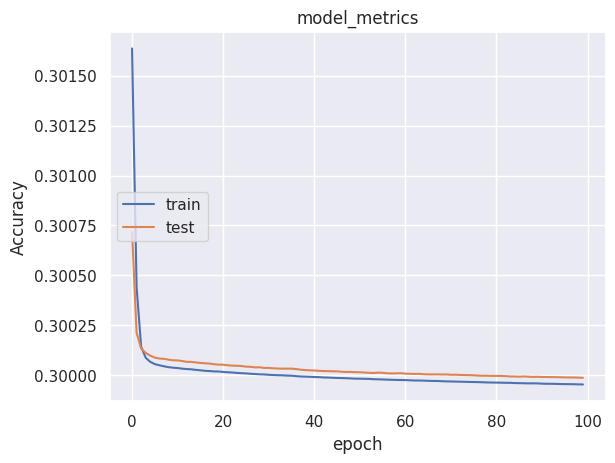

In [46]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
# plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

In [51]:
# Menyiapkan dataframe
place_df = place[['id_resto','kategori']]
place_df.columns = ['id','category']

In [52]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
user_id

282.0

In [53]:
# Mencari umur dari user
user_age = df.loc[df['User_Id'] == user_id]
user_age = user_age['Age'].values[1]
user_age

39.0

In [54]:
# Melakukan prediksi dari usia user
category_recomm = model.predict([[user_age]]).flatten()
print(category_recomm)

category_recomm2 = np.array(category_recomm)
category_recomm2.sort()

i=9
highest1 = 0
highest2 = 0
highest3 = 0
while i>=0:
  if category_recomm[i]==category_recomm2[9]:
    highest1 = i
  elif category_recomm[i]==category_recomm2[8]:
    highest2 = i
  elif category_recomm[i]==category_recomm2[7]:
    highest3 = i
  i-=1
print(highest1,highest2,highest3)

cat_name1 = category_encoded_to_category.get(highest1)
cat_name2 = category_encoded_to_category.get(highest2)
cat_name3 = category_encoded_to_category.get(highest3)
print(cat_name1,cat_name2,cat_name3)


cat1 = place_df[place_df.category == cat_name1]
suggest1 = cat1.head(15)
if len(suggest1)>2:
  suggest1 = suggest1.sample(2)
else:
  suggest1 = suggest1.sample(len(suggest1))


cat2 = place_df[place_df.category == cat_name2]
suggest2 = cat2.head(15)
if len(suggest2)>2:
  suggest2 = suggest2.sample(2)
else:
  suggest2 = suggest2.sample(len(suggest2))


cat3 = place_df[place_df.category == cat_name3]
suggest3 = cat3.head(15)
len(suggest3)
if len(suggest3)>2:
  suggest3 = suggest3.sample(2)
else:
  suggest3 = suggest3.sample(len(suggest3))



final_suggestion = []
for i in range(len(suggest1)):
  final_suggestion.append(suggest1['id'].values[i])

for i in range(len(suggest2)):
  final_suggestion.append(suggest2['id'].values[i])

for i in range(len(suggest3)):
  final_suggestion.append(suggest3['id'].values[i])

final_suggestion

1/1 [==============================] - 0s 167ms/step
[0.09340331 0.12899931 0.10354853 0.10266445 0.11488458 0.08883853
 0.05190361 0.11939273 0.10443287 0.09193218]
1 7 4
Restoran Vegetarian / Vegan Restoran Barat (Western Restaurant) Restoran Italia (Italian Restaurant)


[88, 111, 19, 96, 87, 106]